In [5]:
from BRScraper import nba
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# loading in the datasets
train_df = pd.read_csv('nba_combined_1980_2015.csv')
test_df = pd.read_csv('nba_combined_2016_2024.csv')

def mark_mvp_candidates(df):
    # creating this new data frame to avoid modifying the original one
    df = df.copy()
    
    # initializing MVP_Class to 0
    df['MVP_Class'] = 0
    
    # processing the data, season by season
    for season in df['Season'].unique():
        season_mask = df['Season'] == season
        season_data = df[season_mask]
        
        # filtering for players who were nominated for MVP that season
        nominated_mask = season_data['Nominated'] == 1
        nominated_players = season_data[nominated_mask]
        
        if len(nominated_players) >= 5:
            # getting the top 5 nominees by EFF
            top_5_indices = nominated_players.nlargest(5, 'EFF').index
            # setting MVP_Class to 1 for these players
            df.loc[top_5_indices, 'MVP_Class'] = 1
    
    return df

# marking the MVP candidates in both datasets
train_df = mark_mvp_candidates(train_df)
test_df = mark_mvp_candidates(test_df)

print("Training Data MVP_Class Distribution:")
print(train_df['MVP_Class'].value_counts(normalize=True))

# defining features
features = ['G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3P%', '2P', '2P%', 'eFG%','FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK','TOV', 'PTS', 'TS%', 'EFF']

X = train_df[features]
y = train_df['MVP_Class'] # this is the label we'll be using to predict whether a player is in the Top-5 MVP list

# splitting the data with an 80/20 split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42, stratify=y)

# using SimpleImputer to handle any missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns)

# scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

# applying SMOTE for to handle class imbalances
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# training the DummyClassifier model
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train_balanced, y_train_balanced)

Training Data MVP_Class Distribution:
MVP_Class
0    0.988088
1    0.011912
Name: proportion, dtype: float64


DummyClassifier(random_state=42, strategy='stratified')

Now lets try to predict the top 5 nominees for the MVP award in the 2023-24 season

In [7]:
# Now let's try predicting the top 5 nominees for the 2023-24 season
season_2024 = test_df[test_df['Season'] == '2023-24'].copy()
X_2024 = season_2024[features]

# preprocessing 2023-24 data
X_2024_imputed = pd.DataFrame(
    imputer.transform(X_2024),
    columns=X_2024.columns
)
X_2024_scaled = scaler.transform(X_2024_imputed)

# Get predictions
pred_proba = dummy_clf.predict_proba(X_2024_scaled)[:, 1]
season_2024['MVP_Probability'] = pred_proba

# Show top 5 predictions
print("\nTop 5 Predicted MVP Candidates for 2023-24 Season:")
top_5 = season_2024.nlargest(5, 'MVP_Probability')[
    ['Player', 'Team', 'MVP_Probability', 'PTS', 'TRB', 'AST', 'EFF', 'MVP_Class']
]
print(top_5.round(3))

# Print model performance metrics
y_pred = dummy_clf.predict(scaler.transform(imputer.transform(X_val)))
print("\nValidation Set Performance:")
print(f"Recall Score: {recall_score(y_val, y_pred):.3f}")
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_pred):.3f}")


Top 5 Predicted MVP Candidates for 2023-24 Season:
             Player Team  MVP_Probability   PTS   TRB  AST   EFF  MVP_Class
3883    Joel Embiid  PHI              1.0  34.7  11.0  5.6  0.99          1
3887  Jalen Brunson  NYK              1.0  28.7   3.6  6.7  0.33          0
3888   Devin Booker  PHO              1.0  27.1   4.5  6.9  0.39          0
3889   Kevin Durant  PHO              1.0  27.1   6.6  5.0  0.37          0
3893  Stephen Curry  GSW              1.0  26.4   4.5  5.1  0.31          0

Validation Set Performance:
Recall Score: 0.639
ROC-AUC Score: 0.573


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [8]:
# Get MVP votings from 2023
print(nba.get_award_votings('mvp', 2023).head(5))

  Rank                   Player  Age   Tm  Voting_First  Voting_Pts Won  \
0    1              Joel Embiid   28  PHI            73             915   
1    2             Nikola Jokić   27  DEN            15             674   
2    3    Giannis Antetokounmpo   28  MIL            12             606   
3    4             Jayson Tatum   24  BOS             0             280   
4    5  Shai Gilgeous-Alexander   24  OKC             0              46   

   Voting_Pts Max  Voting_Share   G  Per Game_MP  Per Game_PTS  Per Game_TRB  \
0            1000         0.915  66         34.6          33.1          10.2   
1            1000         0.674  69         33.7          24.5          11.8   
2            1000         0.606  63         32.1          31.1          11.8   
3            1000         0.280  74         36.9          30.1           8.8   
4            1000         0.046  68         35.5          31.4           4.8   

   Per Game_AST  Per Game_STL  Per Game_BLK  Shooting_FG%  Shooting_

Recall of 0.639 means that approximately 64% of the actual MVP candidates in the validation set were correctly identified by the model.

ROC-AUC of 0.573 indicates the model is somewhat better than random, but still quite poor at distinguishing between the two classe (non-MVP and MVP).

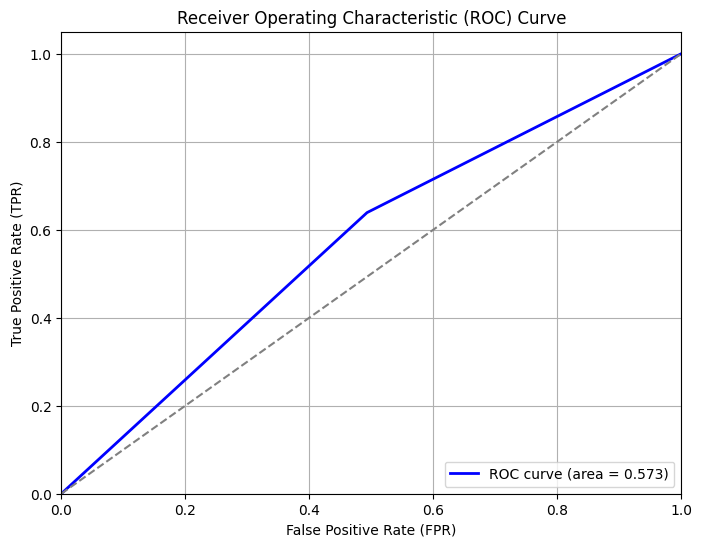

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

# calculating the ROC curve values
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

# plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()